In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
events_data = pd.read_csv('event_data_train.csv')
submissions_data = pd.read_csv('submissions_data_train.csv')

## events_data

In [3]:
events_data.head(5)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day']=events_data.date.dt.date
events_data.head(5)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [5]:
print(f'Дата первого события: {events_data.date.min()}, Дата последнего: {events_data.date.max()}')

Дата первого события: 2015-06-15 04:00:48, Дата последнего: 2018-05-19 23:33:31


In [6]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
day                  object
dtype: object

### Количество уникальных пользователей по дням

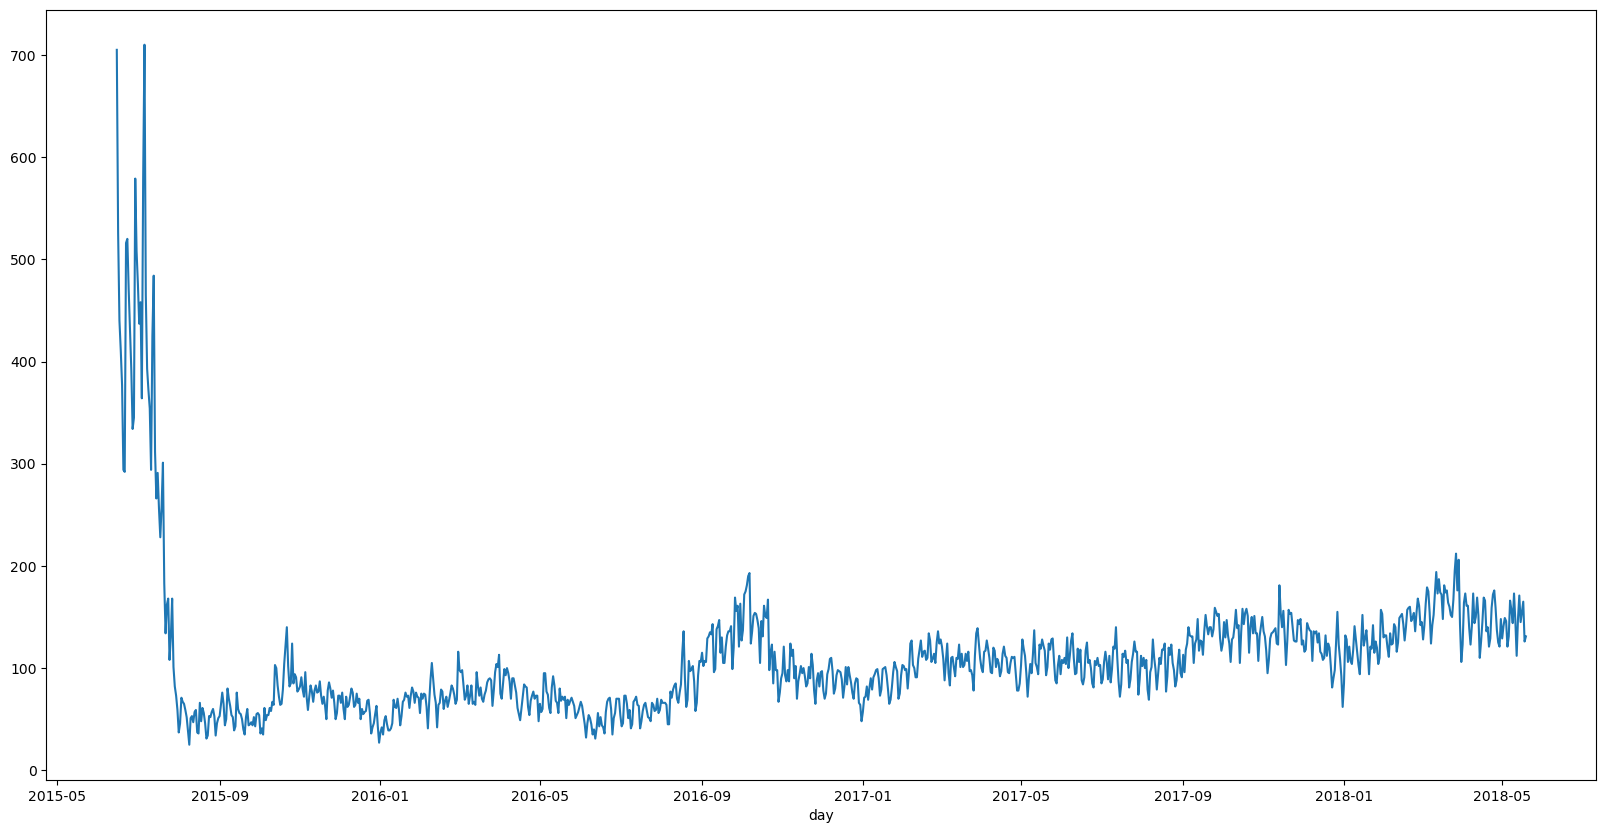

In [7]:
events_data.groupby('day') \
    .user_id.nunique().plot(figsize=(20,10))
plt.show()

In [8]:
pivot_table_action = events_data.pivot_table(index='user_id', 
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0)
pivot_table_action.head(5)

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


In [9]:
pivot_table_action.shape

(19234, 4)

## submissions_data

In [10]:
submissions_data.head(5)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [11]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [12]:
user_scores = submissions_data.pivot_table(index='user_id', 
                       columns='submission_status',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0)
user_scores

submission_status,correct,wrong
user_id,,
2,2,0
3,29,23
5,2,2
8,9,21
14,0,1
...,...,...
26787,3,0
26790,1,0
26794,33,9


## Создание датафрейма с юзерами и их последними входами на образовательную платформу

In [13]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp':'max'}) \
    .rename(columns={'timestamp':'last_timestamp'})

In [14]:
users_data

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


## Создам новую переменную с меткой is_gone_user, у которой будет 2 состояния: 0 и 1 (не ушел/ушел)

Если разница между последней датой в датафрейме и последним входом юзера больше чем 30 дней, то значит юзер забросил курс

In [15]:
dropout_threshold = 30 * 24 * 60 * 60
dropout_threshold

2592000

In [16]:
last_timestamp_df = events_data.timestamp.max()
last_timestamp_df

1526772811

In [17]:
users_data['is_gone_user'] = (last_timestamp_df - users_data.last_timestamp) > dropout_threshold
users_data.head(5)

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


## Теперь осталось уточнить, прошли ли курс пользователи, если прошли, то выписать их из забросивших курс, а также, собрать датафрейм users_data со всеми известными данными

In [18]:
user_scores = user_scores.reset_index()
user_scores.head(5)

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [19]:
users_data = users_data.merge(user_scores, how='outer', on='user_id')
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,NaN,NaN
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [20]:
users_data = users_data.fillna(0)

In [21]:
pivot_table_action = pivot_table_action.reset_index()
pivot_table_action.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [22]:
users_data = users_data.merge(pivot_table_action, on = 'user_id', how= 'inner')

In [23]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9
19230,26793,1510225034,True,0.0,0.0,1,0,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180
19232,26797,1509995096,True,2.0,0.0,10,10,2,13


### Добавлю в users_data переменную с количеством уникальных дней для каждого юзера, которые он провел на образовательной платформе

In [24]:
users_days = events_data.groupby('user_id').day.nunique()
users_days = users_days.to_frame().reset_index()
users_days.head(5)

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [25]:
users_data = users_data.merge(users_days, on='user_id')
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


### Теперь добавлю колонку, где будет указана метка, прошел ли человек курс или нет, для этого он должен набрать больше 170 баллов

In [26]:
users_data['passed_course'] = users_data['passed'] > 170
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


Половина пользователей решает больше 20 дней

In [27]:
users_data[users_data.passed_course == True].day.median()

20.0

Найду для каждого юзера время, когда он первый раз заходил

In [28]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp':'min'}) \
    .rename({'timestamp':'min_timestamp'}, axis = 1)
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [29]:
users_data = users_data.merge(user_min_time, how = 'inner')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Теперь, в event_data нужно отобрать те наблюдения, которые проходят по некоторому условию.

Для каждого юзера есть промежуток(первые 3 дня, потому что моя цель узнать, можно ли на основе действий пользователя в течение 3 дней предсказать, уйдет он с курса или нет), в который можно уместить все наблюдения.

In [30]:
learning_time_threshold =3 * 24 * 60 * 60

In [31]:
events_data_train = events_data.merge(user_min_time, on = 'user_id', how='left')
events_data_train

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848
...,...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19,1511358209
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19,1526772750


In [32]:
events_data_train['min_timestamp+3days'] = events_data_train.min_timestamp + learning_time_threshold
events_data_train

,step_id,timestamp,action,user_id,date,day,min_timestamp,min_timestamp+3days
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,1434600048
...,...,...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19,1511358209,1511617409
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750,1527031950
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750,1527031950
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19,1526772750,1527031950


In [33]:
events_data_train = events_data_train[events_data_train['timestamp'] <=events_data_train['min_timestamp+3days']]
events_data_train

,step_id,timestamp,action,user_id,date,day,min_timestamp,min_timestamp+3days
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,1434600048
...,...,...,...,...,...,...,...,...
3480530,32953,1526766998,viewed,24555,2018-05-19 21:56:38,2018-05-19,1526729867,1526989067
3480531,32953,1526766998,discovered,24555,2018-05-19 21:56:38,2018-05-19,1526729867,1526989067
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750,1527031950
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750,1527031950


In [34]:
events_data_train.user_id.nunique()

19234

In [35]:
events_data_train.groupby('user_id').day.nunique().max()

4

### Преобразования в submissions_data

In [36]:
learning_time_threshold =3 * 24 * 60 * 60
user_learning_time_threshold =  user_min_time.user_id.map(str) \
    + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [37]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

### Добавлю колонку, где будет информация о том, сколько юзер пробыл на Степике(от 1 до 4 дней)

In [38]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns = {'day': 'days'})

In [39]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns = {'step_id': 'steps_tried'})

In [40]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [41]:
X = X.merge(steps_tried, on = 'user_id', how='outer')

### Добавлю колонки с количеством корректно решенных и с количеством неправильно решенных степов

In [42]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                       columns='submission_status',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index(), on='user_id', how='outer')

In [43]:
X.shape

(8913, 5)

In [44]:
X['correct_ratio'] = X['correct'] / (X['correct'] + X['wrong'])

In [45]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()[['user_id','viewed']], how='outer')

In [46]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [47]:
X = X.fillna(0)

In [48]:
X = X.merge(users_data[['user_id','passed_course','is_gone_user']], how='outer')

### Уберу тех юзеров, которые не прошли курс и не забросили его еще

In [49]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [50]:
X.groupby(['passed_course','is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [51]:
y = X.passed_course

In [52]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [53]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
user_id,,,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9,False,True
3,1.0,4.0,4.0,4.0,0.50,20,False,True
8,1.0,11.0,9.0,21.0,0.30,154,False,True
14,1.0,1.0,0.0,1.0,0.00,9,False,True
16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [54]:
X = X.drop(['passed_course','is_gone_user'], axis= 1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


In [55]:
y = y.map(int)

In [56]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: passed_course, dtype: int64

# Обучение модели Random Forest

In [57]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25)

In [58]:
rf_clf = RandomForestClassifier(random_state=42)

In [59]:
params = {'n_estimators': range(10,51,10), 
          'max_depth': range(1,  15, 2), 
          'min_samples_leaf': range(1,8), 'min_samples_split': range(2, 20, 2)}

In [ ]:
# grCV = GridSearchCV(rf_clf, params, cv=5, n_jobs=-1)

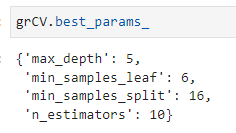

In [70]:
rf_clf = RandomForestClassifier(n_estimators = 10,
                                random_state=42,
                                criterion='entropy',
                                max_depth = 7,
                                min_samples_leaf = 6,
                                min_samples_split = 16 )
rf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_leaf=6,
                       min_samples_split=16, n_estimators=10, random_state=42)

In [61]:
#grCV.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 20, 2),
                         'n_estimators': range(10, 51, 10)})

In [62]:
#grCV.best_params_

{'max_depth': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 16,
 'n_estimators': 10}

In [63]:
#best_rf_clf = grCV.best_estimator_

In [71]:
y_predicted = rf_clf.predict(X_test)
y_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [72]:
rf_clf.score(X_test,y_test)

0.9241716700022237

In [73]:
precision_score(y_test, y_predicted, average='macro')

0.7397405217568402

In [74]:
recall_score(y_test, y_predicted)

0.11206896551724138

In [75]:
cross_val_score(rf_clf, X_train,y_train,cv=5).mean()

0.92200476437455

In [91]:
#disp = plot_confusion_matrix(rf_clf, X_test, y_test, cmap = plt.cm.Blues)
#disp.ax_.set_title('Confusion Matrix')
#plt.show()

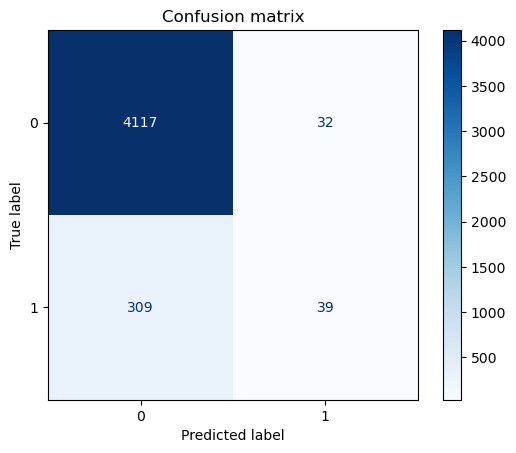

In [90]:
disp = ConfusionMatrixDisplay.from_estimator(
        rf_clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=None)
disp.ax_.set_title("Confusion matrix")

plt.show()

In [77]:
features_importances = rf_clf.feature_importances_
features_importances

array([0.14883545, 0.24673707, 0.33032731, 0.03231478, 0.16952464,
       0.07226075])

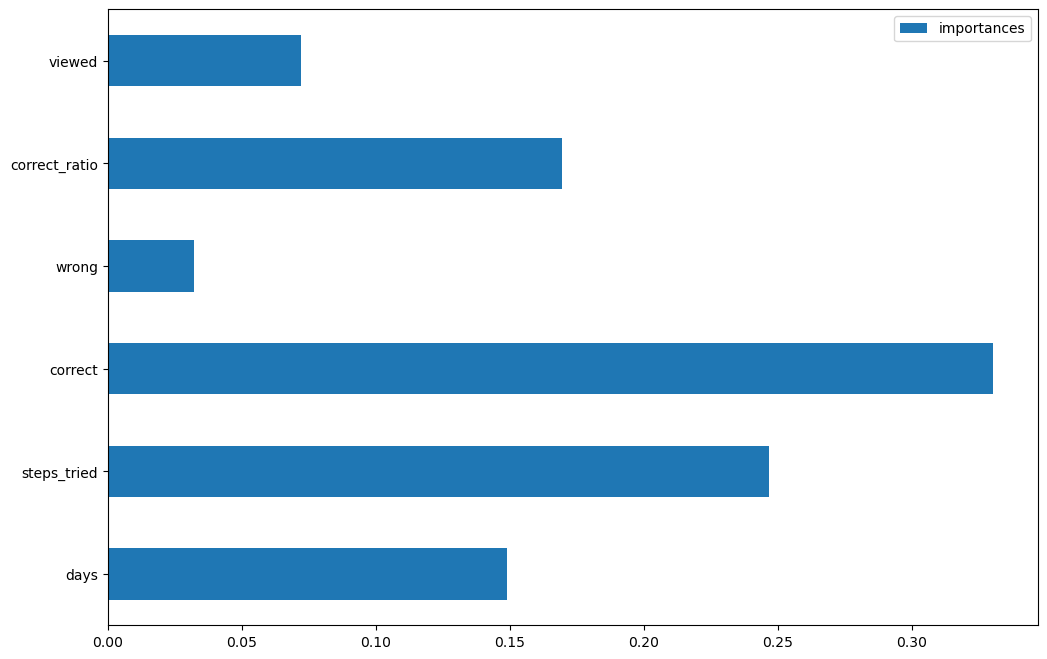

In [79]:
importances_df = pd.DataFrame(features_importances, index=list(X_train.columns), columns=['importances'])
importances_df.plot(kind='barh', figsize=(12, 8))
plt.show()

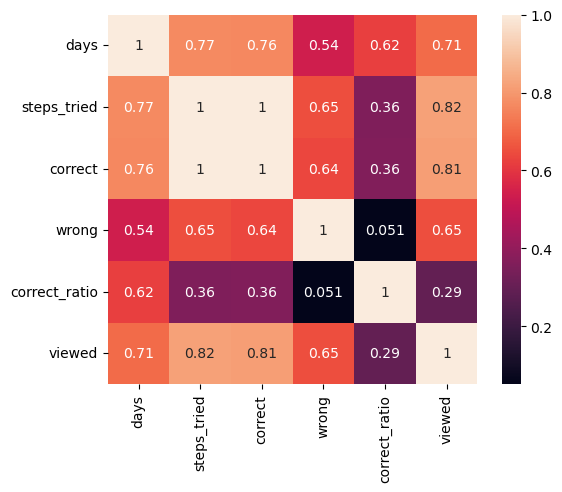

In [80]:
corr = X_train.corr()
sns.heatmap(corr,square=True,annot=True)
plt.show()

## Построение ROC-кривой 

<AxesSubplot: >

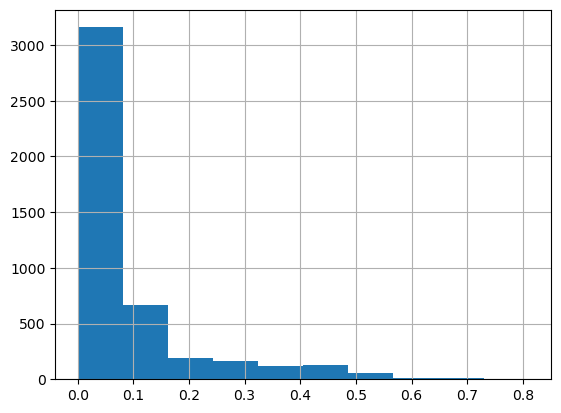

In [93]:
y_predicted_prob = rf_clf.predict_proba(X_test)
pd.Series(y_predicted_prob[:,1]).hist()

In [164]:
y_predicted_new_condition = np.where(y_predicted_prob[:,1] > 0.05, 1, 0)
y_predicted_new_condition

array([1, 1, 0, ..., 1, 0, 0])

In [95]:
y_predicted_new_condition.shape

(4497,)

In [165]:
recall_score(y_test,y_predicted_new_condition)

0.853448275862069

In [166]:
precision_score(y_test,y_predicted_new_condition)

0.1789156626506024

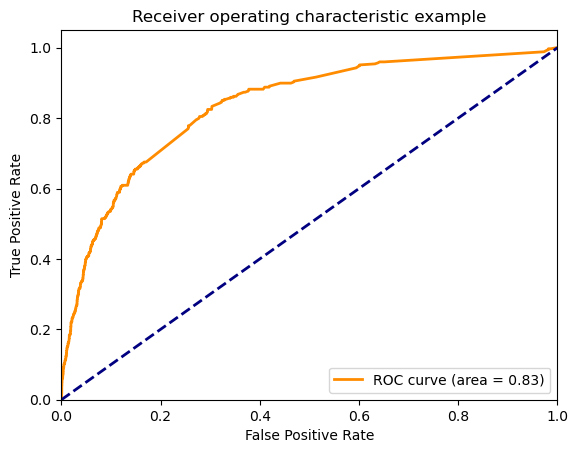

In [158]:
from sklearn.metrics import roc_curve, auc
lw=2
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Итоги

Это первый опыт работы с машинным обучением и вот что можно сказать насчет проделанного:

- Получилось подготовить данные к построению модели, выделив целевую переменную после многочисленных преобразований
- Удалось поработать с методами по подбору параметров и построить модель Random Forest
- Получены знания как проверять качество модели на кросс-валидации, считать Precision, Recall, Accuracy и т.д., 
    поэксперементировать с вероятностями отнесения к тому или иному классу(по большей части благодаря ROC-кривой)
- Построены матрица ошибок и гистограмма вклада каждой переменной в классификацию

Построить идеально работающую модель с хорошими метриками все же не вышло, но получилось преобразовать данные и научиться выделять целевую переменную, узнать наиболее важные для классификации переменные, работать с методами sklearn, pandas, numpy, matplotlib.